# Laboratorio 3  - CNN para clasificar imágenes
## José Antonio Álvarez, Celia Banegas, Javier Pardo

Primero importamos nuestra librerias para nuestra práctica

In [ ]:
import tensorflow as tensor
import numpy as np
import matplotlib.pyplot as pl
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten
import zipfile
import shutil
from collections import defaultdict
from random import sample
import pandas as pd
from shutil import copyfile
import random
from PIL import Image
from google.colab import drive
import os
from shutil import copyfile

## Importación del dataset

In [ ]:
# Monta Google Drive
drive.mount('/content/drive', force_remount=True)

# Especifica la ruta al archivo zip en tu Google Drive
zip_path = '/content/drive/My Drive/state-farm-distracted-driver-detection.zip'  # Ajusta la ruta según donde esté el archivo

# Especifica la carpeta de destino donde deseas descomprimir los archivos
destination_path = '/content/state-farm-distracted-driver-detection'

# Crea la carpeta de destino si no existe
if not os.path.exists(destination_path):
    os.makedirs(destination_path)

# Descomprime el archivo zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(destination_path)

print("Archivos descomprimidos con éxito:")
os.listdir(destination_path)  # Muestra los archivos en la carpeta descomprimida

Mounted at /content/drive
Archivos descomprimidos con éxito:


['driver_imgs_list.csv', 'sample_submission.csv', 'imgs']

**Reducción de la dimensionalidad**

In [ ]:
import os
import pandas as pd

# Ruta al archivo CSV
csv_file_path = '/content/state-farm-distracted-driver-detection/driver_imgs_list.csv'

# Leer el archivo CSV
df = pd.read_csv(csv_file_path)

# Reducir el DataFrame en un 25%
reduced_df = df.sample(frac=0.75, random_state=42)  # 'frac' es la fracción del dataset que quieres mantener

# Identificar las filas que no están en el dataframe reducido
df_dropped = df.drop(reduced_df.index)

# Ruta a la carpeta de imágenes
images_path = '/content/state-farm-distracted-driver-detection/imgs/train'

# Eliminar las imágenes correspondientes a las filas eliminadas
for index, row in df_dropped.iterrows():
    image_file = os.path.join(images_path, row['classname'], row['img'])
    if os.path.exists(image_file):
        os.remove(image_file)

print("Se ha eliminado el 25% de las imágenes.")



Se ha eliminado el 25% de las imágenes.




Balanceamos el dataset

In [ ]:
# Ruta a la carpeta de imágenes
train_path = '/content/state-farm-distracted-driver-detection/imgs/train'

# Lista para almacenar las rutas de las subcarpetas
class_folders = os.listdir(train_path)

# Diccionario para almacenar los conteos
image_counts = {}

# Iterar a través de las subcarpetas y contar los archivos
for class_folder in class_folders:
    folder_path = os.path.join(train_path, class_folder)
    image_counts[class_folder] = len(os.listdir(folder_path))

# Imprimir el número de imágenes por carpeta
for class_folder, count in image_counts.items():
    print(f"Carpeta {class_folder}: {count} imágenes")

Carpeta c1: 1699 imágenes
Carpeta c9: 1585 imágenes
Carpeta c4: 1732 imágenes
Carpeta c5: 1742 imágenes
Carpeta c8: 1429 imágenes
Carpeta c0: 1856 imágenes
Carpeta c6: 1743 imágenes
Carpeta c3: 1748 imágenes
Carpeta c7: 1547 imágenes
Carpeta c2: 1737 imágenes


In [ ]:
# Obtener el número máximo de imágenes en cualquier clase
max_count = max(image_counts.values())

# Realizar el sobremuestreo para cada clase
for class_folder in class_folders:
    folder_path = os.path.join(train_path, class_folder)
    images = os.listdir(folder_path)
    count = len(images)
    while count < max_count:
        # Escoger una imagen aleatoria para copiar
        image_to_copy = random.choice(images)
        # Crear un nuevo nombre de archivo único para la imagen copiada
        new_image_name = f'copy_{count}_{image_to_copy}'
        # Ruta de la nueva imagen
        copy_path = os.path.join(folder_path, new_image_name)
        # Ruta de la imagen existente
        original_image_path = os.path.join(folder_path, image_to_copy)
        # Copiar la imagen
        copyfile(original_image_path, copy_path)
        count += 1

print("Las clases han sido balanceadas.")

# Iterar a través de las subcarpetas y contar los archivos
for class_folder in class_folders:
    folder_path = os.path.join(train_path, class_folder)
    image_counts[class_folder] = len(os.listdir(folder_path))

# Imprimir el número de imágenes por carpeta
for class_folder, count in image_counts.items():
    print(f"Carpeta {class_folder}: {count} imágenes")


Las clases han sido balanceadas.
Carpeta c1: 1856 imágenes
Carpeta c9: 1856 imágenes
Carpeta c4: 1856 imágenes
Carpeta c5: 1856 imágenes
Carpeta c8: 1856 imágenes
Carpeta c0: 1856 imágenes
Carpeta c6: 1856 imágenes
Carpeta c3: 1856 imágenes
Carpeta c7: 1856 imágenes
Carpeta c2: 1856 imágenes


Tras realizar el balanceo de clases procedemos a dividir el dataset en entrenamiento 80% y 20% validación, ya que ya tenemos las imágenes para el test.

In [ ]:
import os
from sklearn.model_selection import train_test_split

# Directories for the splits
train_dir = 'train_split'
val_dir = 'val_split'
test_dir = 'test_split'

# Create directories for the splits if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Split each class directory
for class_folder in class_folders:
    images = os.listdir(os.path.join(train_path, class_folder))

    # First, split the data into test and remaining images
    remaining_imgs, test_imgs = train_test_split(images, test_size=0.1, random_state=42)

    # Now split the remaining images into train and validation
    train_imgs, val_imgs = train_test_split(remaining_imgs, test_size=0.2, random_state=42)

    # Create class folders in train, validation, and test directories
    os.makedirs(os.path.join(train_dir, class_folder), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_folder), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_folder), exist_ok=True)

    # Copy images to their respective directories
    for img in train_imgs:
        source = os.path.join(train_path, class_folder, img)
        destination = os.path.join(train_dir, class_folder, img)
        shutil.copyfile(source, destination)

    for img in val_imgs:
        source = os.path.join(train_path, class_folder, img)
        destination = os.path.join(val_dir, class_folder, img)
        shutil.copyfile(source, destination)

    for img in test_imgs:
        source = os.path.join(train_path, class_folder, img)
        destination = os.path.join(test_dir, class_folder, img)
        shutil.copyfile(source, destination)

print("Dataset successfully split into training, validation, and test sets.")


Dataset successfully split into training, validation, and test sets.


## Redimensionamiento de datos

Normalizamos los pixeles porque se mueven en un rango de 1 a 255-256.

In [ ]:
# Importamos la clase ImageDataGenerator desde el módulo de preprocesamiento de imágenes de Keras.
# Este reescalamiento normaliza los valores de los píxeles de las imágenes dividiéndolos entre 255.
train_datagen = ImageDataGenerator(rescale=1./255)

# Se inicializa un generador de datos de validación con un factor de reescalamiento similar al del generador de entrenamiento.
val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)


# 'train_generator' es un iterador que genera lotes de imágenes de entrenamiento escaladas y sus etiquetas correspondientes.
# Las imágenes se cargarán desde 'train_dir', se redimensionarán a un tamaño de 224x224 píxeles,
# se procesarán en lotes de 32 imágenes y las etiquetas se manejarán en modo 'sparse' (escasas),
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Se asume que deseamos redimensionar las imágenes a 224x224 píxeles
    batch_size=32,
    class_mode='sparse'  # Esto aplanará automáticamente las etiquetas
)


# Esto garantiza que los datos de validación se procesen de la misma manera que los datos de entrenamiento.
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),  # Se aplica el mismo redimensionamiento para las imágenes de validación
    batch_size=32,
    class_mode='sparse'  # También aplanará las etiquetas
)

# Esto garantiza que los datos de test se procesen de la misma manera que los datos de entrenamiento.
test_datagen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),  # Se aplica el mismo redimensionamiento para las imágenes de validación
    batch_size=32,
    class_mode='sparse'  # También aplanará las etiquetas
)



Found 13360 images belonging to 10 classes.
Found 3340 images belonging to 10 classes.
Found 1860 images belonging to 10 classes.


## Definición del modelo CNN

Lo primero que hacemos es definir el numero de clases de nuestro set de entrenamiento

In [ ]:
num = 10

10

Ahora, lo que hacemos crear la primera capa de convolución de nuestro modelo

In [ ]:
input_shape = (224, 224, 3)  # Definimos la forma de entrada esperada como 224x224 píxeles con 3 canales (RGB)
inputs = Input(shape=input_shape)

x = Conv2D(512, (3,3), activation='relu', padding='same')(inputs)
x = MaxPooling2D((2,2))(x)
x = Conv2D(256, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2))(x)
x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2))(x)
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2))(x)


A continuación, lo que hacemos aplanar el modelo y establecemos como criterio de parada, tal y como nos pone el enunciado, de 0,2

In [ ]:
x = Flatten()(x)
x = Dropout(0.2)(x)  # Aplicamos un dropout de 0.2

La capa oculta, también la establecemos, con un tamaño de 600, por ejemplo, su función de activación también debe ser RELU y su criterio de parada de 0.2

In [ ]:
x = Dense(600, activation='relu')(x) #dense 600 funciona
x = Dropout(0.2)(x)

Por último, la capa de salida, la establecemos, con el numero de clases, 10, pero la función de activación debe ser SOFTMAX

In [ ]:
outputs = Dense(num, activation='softmax')(x)  # Capa de salida con softmax

Definimos el modelo y mostramos cómo está compuesto

In [ ]:
# Construir y compilar el modelo
model = Model(inputs, outputs)

# Mostrar el resumen del modelo
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 512)     14336     
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 512)     0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 256)     1179904   
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       295040

## Compilación del modelo

Una vez tenemos nuestro modelo, vamos a compilarlo.

Para ello, usaremos el optimizador ADAM y la función de error ‘categorical_crossentropy’, incluso podemos cambiar el learning rate, para ver su comportamiento.

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.001),  # Usamos Adam con un learning rate de 0.001
    loss=sparse_categorical_crossentropy,  # Usamos sparse_categorical_crossentropy como función de pérdida
    metrics=['accuracy']  # La métrica que queremos observar es 'accuracy'
)

## Entrenamiento del modelo

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Ruta donde quieres guardar los checkpoints
checkpoint_path = '/content/checkpoints/model-{epoch:02d}-{val_accuracy:.2f}.weights.h5'

# Crear el callback de ModelCheckpoint
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

# Configurar el callback de EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1,
    restore_best_weights=True
)

# Añadir ambos callbacks al entrenamiento
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=[early_stopping, model_checkpoint_callback]
)


Epoch 1/100
418/418 [==============================] - ETA: 0s - loss: 0.8906 - accuracy: 0.6909
Epoch 1: val_accuracy improved from -inf to 0.96737, saving model to /content/checkpoints/model-01-0.97.weights.h5
418/418 [==============================] - 251s 531ms/step - loss: 0.8906 - accuracy: 0.6909 - val_loss: 0.1198 - val_accuracy: 0.9674
Epoch 2/100
418/418 [==============================] - ETA: 0s - loss: 0.1152 - accuracy: 0.9654
Epoch 2: val_accuracy improved from 0.96737 to 0.97814, saving model to /content/checkpoints/model-02-0.98.weights.h5
418/418 [==============================] - 208s 497ms/step - loss: 0.1152 - accuracy: 0.9654 - val_loss: 0.0733 - val_accuracy: 0.9781
Epoch 3/100
418/418 [==============================] - ETA: 0s - loss: 0.0587 - accuracy: 0.9817
Epoch 3: val_accuracy improved from 0.97814 to 0.98114, saving model to /content/checkpoints/model-03-0.98.weights.h5
418/418 [==============================] - 207s 496ms/step - loss: 0.0587 - accuracy: 0.

Una vez, entrenado nuestro modelo, vamos a validarlo con nuestro set de validación

In [ ]:
print('Validacion loss:', history.history['val_loss'][-1])  # Última pérdida de validación
print('Validacion precisión:', history.history['val_accuracy'][-1])  # Última precisión de validación

Validacion loss: 0.05686028674244881
Validacion precisión: 0.9898203611373901


Ahora, podemos pintar una gráfica, para ver la evolución de la precisión por iteración.

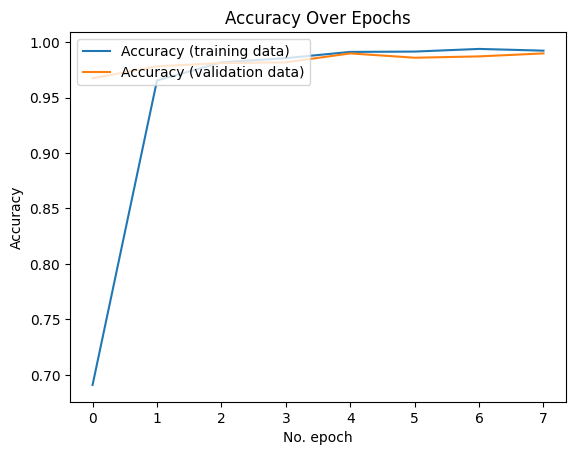

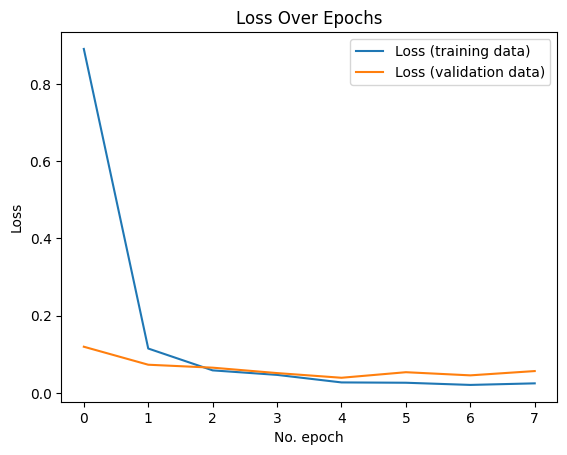

In [ ]:
plt.plot(history.history['accuracy'], label='Accuracy (training data)')
plt.plot(history.history['val_accuracy'], label='Accuracy (validation data)')
plt.title('Accuracy Over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.title('Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()

Found 1860 images belonging to 10 classes.
59/59 [==============================] - 10s 164ms/step


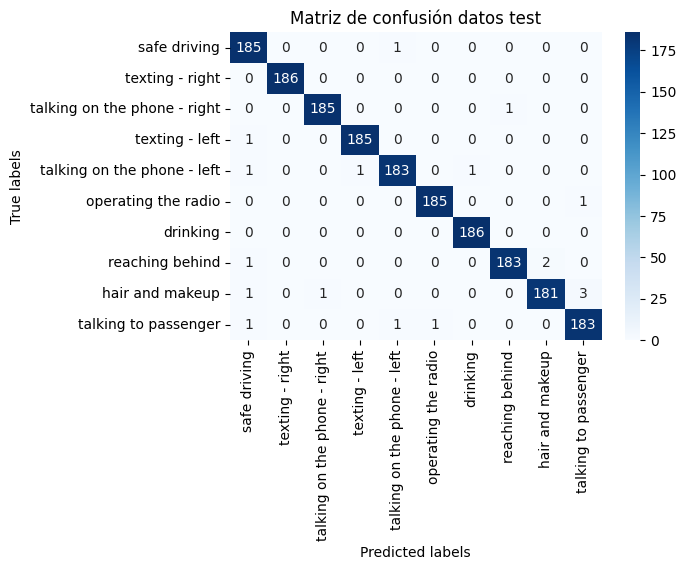

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator

# Definir las etiquetas de clase
class_labels = [
    'safe driving',
    'texting - right',
    'talking on the phone - right',
    'texting - left',
    'talking on the phone - left',
    'operating the radio',
    'drinking',
    'reaching behind',
    'hair and makeup',
    'talking to passenger'
]

# Configurar el generador de datos para el conjunto de test
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',  # 'sparse' si tus etiquetas son enteros, 'categorical' si son one-hot encoded
    shuffle=False  # Importante para mantener el orden y que corresponda con las etiquetas verdaderas
)

# Obtener las predicciones del modelo en el conjunto de datos de test
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas verdaderas del conjunto de datos de test
true_classes = test_generator.classes

# Calcular la matriz de confusión para el conjunto de test
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Visualizar la matriz de confusión para el conjunto de test
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Matriz de confusión datos test')
plt.show()


## Predicción del modelo

Para acabar nuestra práctica, vamos a hacer una predicción, para ver qué tal se comporta nuestra red.

1/1 [==============================] - 1s 692ms/step


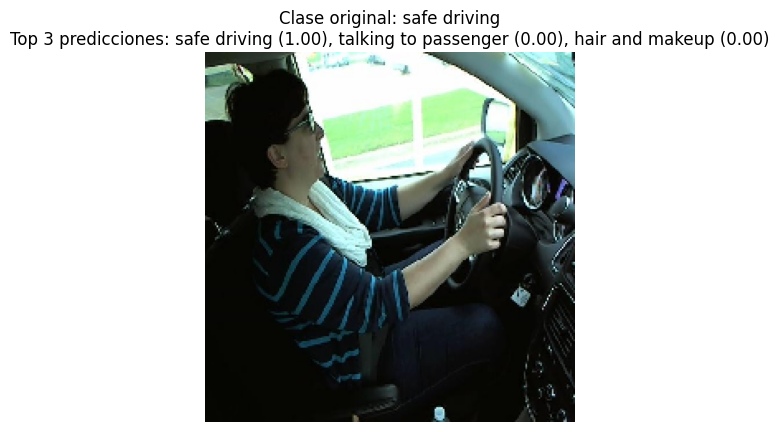

1/1 [==============================] - 0s 17ms/step


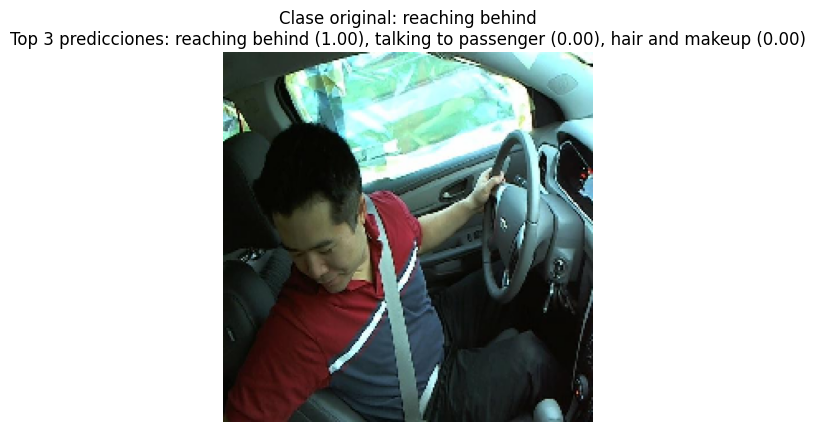

1/1 [==============================] - 0s 19ms/step


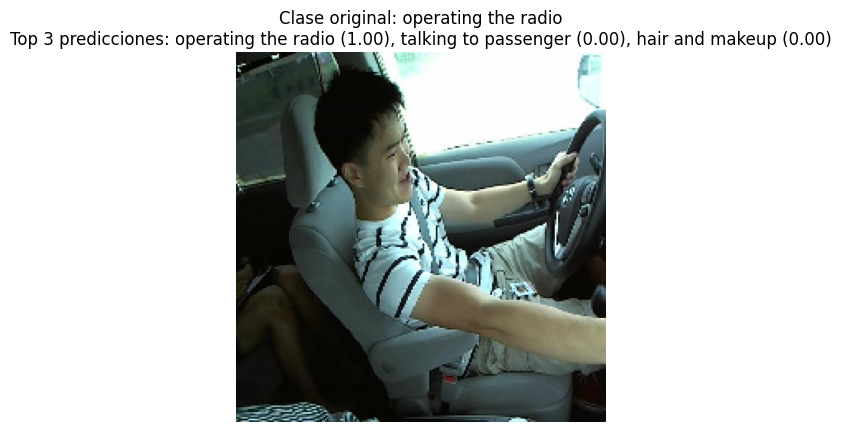

1/1 [==============================] - 0s 20ms/step


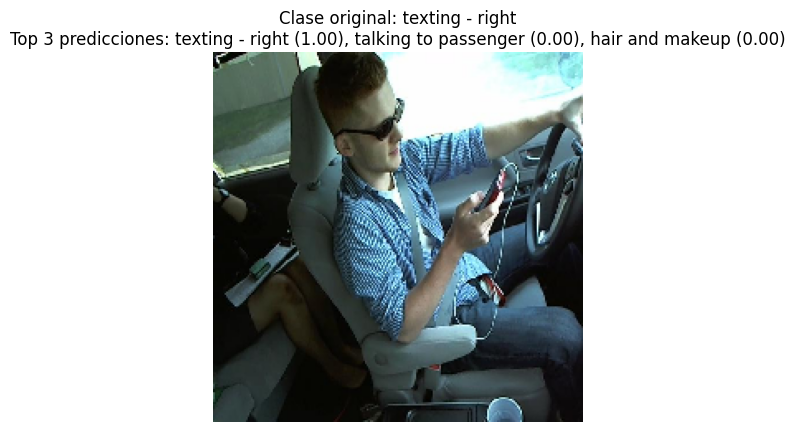

1/1 [==============================] - 0s 33ms/step


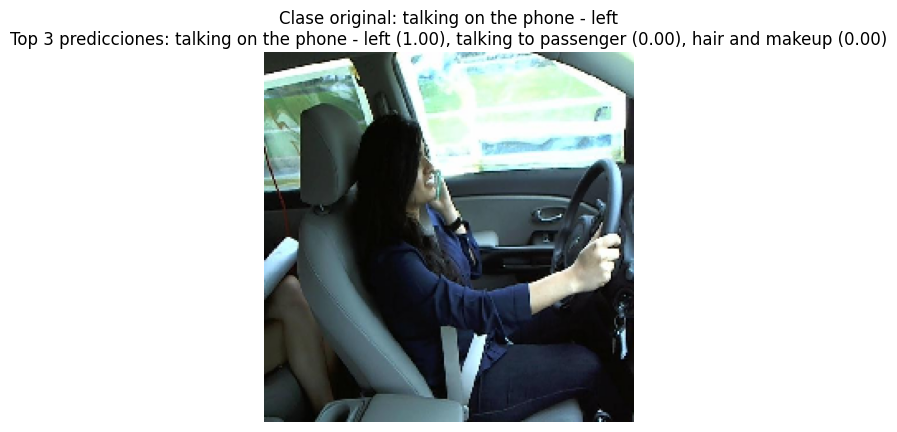

1/1 [==============================] - 0s 23ms/step


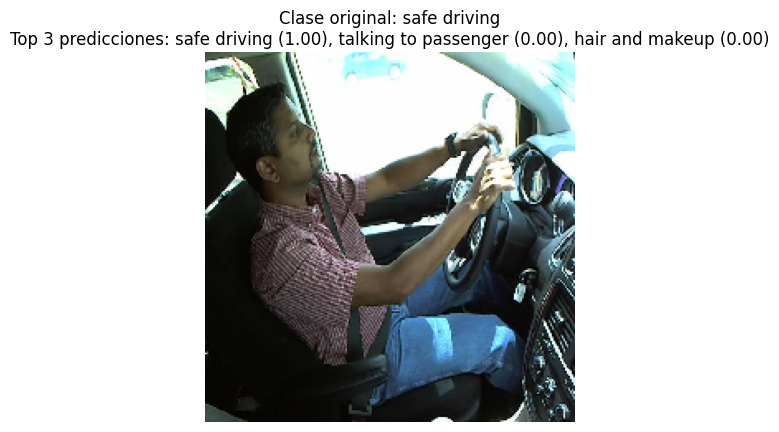

1/1 [==============================] - 0s 23ms/step


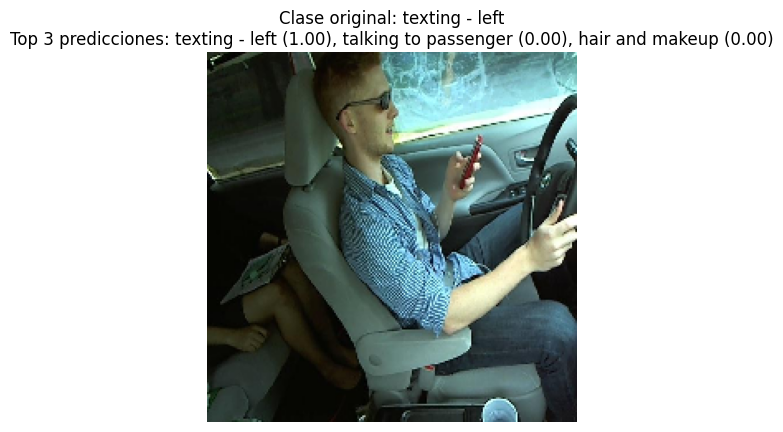

1/1 [==============================] - 0s 26ms/step


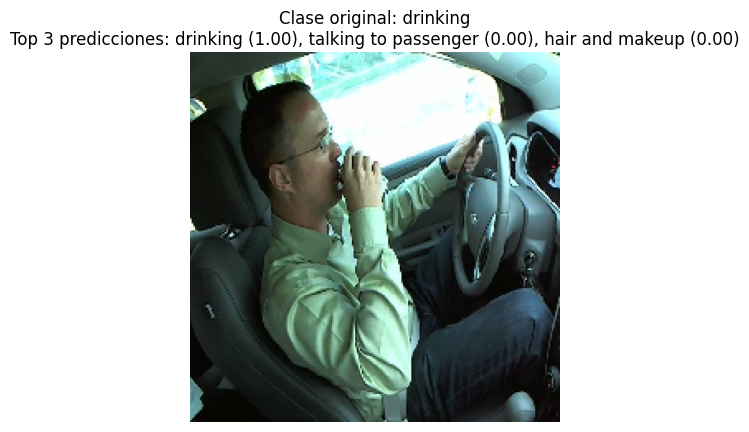

1/1 [==============================] - 0s 25ms/step


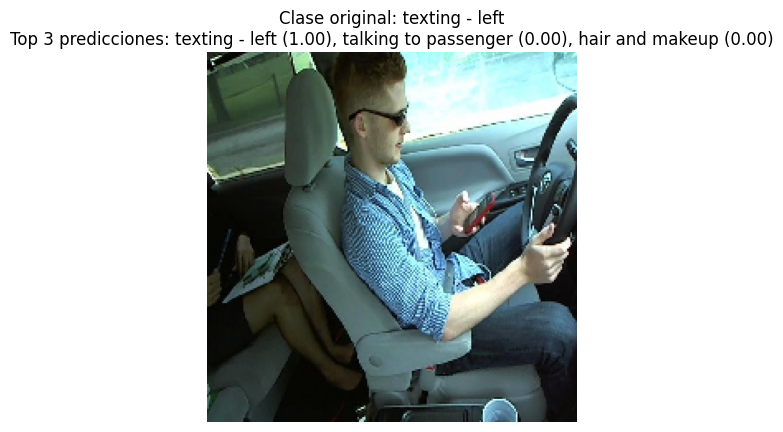

1/1 [==============================] - 0s 26ms/step


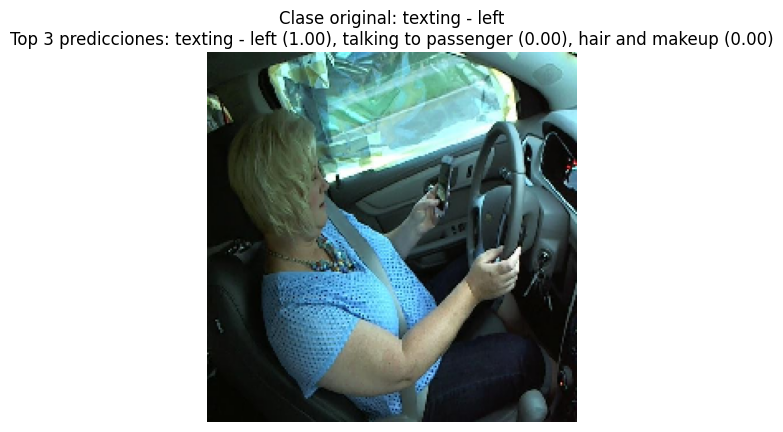

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image

# Definimos las clases como strings para su fácil identificación
clases = [
    "safe driving",
    "texting - right",
    "talking on the phone - right",
    "texting - left",
    "talking on the phone - left",
    "operating the radio",
    "drinking",
    "reaching behind",
    "hair and makeup",
    "talking to passenger"
]

# Aquí adaptamos el generador para trabajar con las imágenes y etiquetas
for _ in range(10):
    # Seleccionamos un índice aleatorio de las imágenes de validación
    img_index = np.random.randint(len(train_generator.filenames))

    # Obtenemos la ruta de la imagen y la etiqueta real
    img_path = train_generator.filepaths[img_index]
    original_class_index = train_generator.labels[img_index]
    original_class = clases[original_class_index]

    # Cargamos y procesamos la imagen
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded = np.expand_dims(img_array, axis=0)

    # Realizamos la predicción y obtenemos las tres clases más probables
    predictions = model.predict(img_array_expanded)
    top_3_indices = np.argsort(predictions[0])[-3:][::-1]
    top_3_classes = [clases[i] for i in top_3_indices]
    top_3_probabilities = predictions[0][top_3_indices]

    # Mostramos la imagen y las tres clases más probables con sus probabilidades
    plt.imshow(img)
    plt.title(f'Clase original: {original_class}\nTop 3 predicciones: ' +
              ', '.join([f'{cl} ({prob:.2f})' for cl, prob in zip(top_3_classes, top_3_probabilities)]))
    plt.axis('off')
    plt.show()
